In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import textblob

import data

# Data Cleaning

In [2]:
train = data.train()
validation = data.validation()
test = data.test()

Just taking a brief look at the topic distribution. It appears that it's not even for each test set. 

In [3]:
train['topic'].unique(), validation['topic'].unique(), test['topic'].unique()

(array(['ordinary_life', 'school_life', 'culture_education',
        'attitude_emotion', 'relationship', 'tourism', 'health', 'work'],
       dtype=object),
 array(['work'], dtype=object),
 array(['work', 'politics', 'finance'], dtype=object))

Yeah the original dataset is simply sorted topics. I can't trust the topics. Not only that, they aren't really meaningful from one dataset to the next.

In [4]:
topics = pd.read_csv('data/ijcnlp_dailydialog/dialogues_topic.txt') # original unparsed
topics = topics['1']

print('Train dataset unique: {}\n'.format(topics[0:11118].unique()))
print('Validation dataset unique: {}\n'.format(topics[11118:12118].unique()))
print('Test dataset unique: {}\n'.format(topics[12118: 13118].unique()))

Train dataset unique: [1 2 3 4 5 6 7 8]

Validation dataset unique: [8]

Test dataset unique: [ 8  9 10]



##### Not going to use Topics for now. 

# Goals of Exploration
- Plot some conversation samples
- Observe and explore why 3 of the major changes in conversations happened?
    - Topics
    - Replies

In [5]:
def _clean(string):
    string = string.lower()
    return string

def word_tokenize(string):
    return string.split(' ')

In [6]:
train

person                                              utter  \
conv                                                                    
0     0   person_a  Say , Jim , how about going for a few beers af...   
      1   person_b   You know that is tempting but is really not g...   
      2   person_a     What do you mean ? It will help us to relax .    
      3   person_b   Do you really think so ? I don't . It will ju...   
      4   person_a   I guess you are right.But what shall we do ? ...   
      5   person_b   I suggest a walk over to the gym where we can...   
      6   person_a   That's a good idea . I hear Mary and Sally of...   
      7   person_b   Sounds great to me ! If they are willing , we...   
      8   person_a                             Good.Let ' s go now .    
      9   person_b                                       All right .    
1     0   person_a                             Can you do push-ups ?    
      1   person_b   Of course I can . It's a piece of cake ! Beli...   
      2   person_a              Really ? I think that's impossible !    
      3   person_b                            You mean 30 push-ups ?    
      4   person_a                                            Yeah !    
      5   person_b   It's easy . If you do exercise everyday , you...   
2     0   person_a                 Can you study with the radio on ?    
      1   person_b               No , I listen to background music .    
      2   person_a                          What is the difference ?    
      3   person_b                The radio has too many comerials .    
      4   person_a   That's true , but then you have to buy a reco...   
3     0   person_a                               Are you all right ?    
      1   person_b   I will be all right soon . I was terrified wh...   
      2   person_a                    Don't worry.He is an acrobat 。    
      3   person_b                                           I see .    
4     0   person_a           Hey John , nice skates . Are they new ?    
      1   person_b   Yeah , I just got them . I started playing ic...   
      2   person_a                       What position do you play ?    
      3   person_b   I ’ m a defender . It ’ s a lot of fun . You ...   
      4   person_a   Yeah , you ’ re a pretty big guy . I play goa...   
...            ...                                                ...   
11113 7   person_b   Then would you kindly come to our shop with t...   
      8   person_a                               Thank you so much !    
11114 0   person_a                 Do you have any seats available ?    
      1   person_b                           Yes . This way please .    
      2   person_a                        What's the special today ?    
      3   person_b               I recommend our New English Pizza .    
      4   person_a   Then give me a large one and an egg drop soup .    
      5   person_b                     Okay . Wait a minute please .    
11115 0   person_a  Uncle Ben , how did the Forbidden City get thi...   
      1   person_b   Well , in the feudal society , emperors had s...   
      2   person_a       His residence ? You mean the whole palace ?    
      3   person_b   Yes . The Forbidden City is divided into two ...   
      4   person_a      Oh , unbelievable . This was too luxurious .    
      5   person_b   Even the whole country belonged to him . That...   
      6   person_a   OK , then . I love these unique structured to...   
      7   person_b   Yeah , the buildings and designs of the Forbi...   
      8   person_a   I agree . It's definitely a product of wisdom...   
      9   person_b   Some of them are mascots and some are symbols...   
      10  person_a   Why are there so many yellow things ? Is yell...   
      11  person_b   Oh , no . In fact , yellow is the symbol of t...   
      12  person_a            Just like the pattern dragon , right ?    
      13  person_b        Exactly . Here is the Nine-dragon Screen .  

person
person_a    AxesSubplot(0.125,0.125;0.775x0.755)
person_b    AxesSubplot(0.125,0.125;0.775x0.755)
Name: polarity, dtype: object

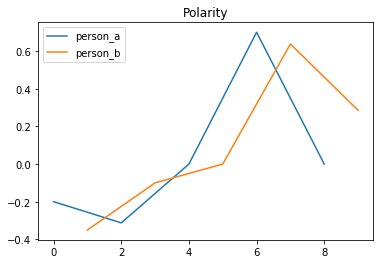

In [37]:
one = train.loc[0]
one.groupby('person')['polarity'].plot(title='Polarity', legend=True)

In [8]:
one

,person,utter,act,emo,polarity,subjectivity,topic
0,person_a,"Say , Jim , how about going for a few beers af...",directive,no_emotion,-0.200000,0.100000,ordinary_life
1,person_b,You know that is tempting but is really not g...,commissive,no_emotion,-0.350000,0.600000,ordinary_life
2,person_a,What do you mean ? It will help us to relax .,question,no_emotion,-0.312500,0.687500,ordinary_life
3,person_b,Do you really think so ? I don't . It will ju...,question,no_emotion,-0.100000,0.380556,ordinary_life
4,person_a,I guess you are right.But what shall we do ? ...,question,no_emotion,0.000000,0.000000,ordinary_life
5,person_b,I suggest a walk over to the gym where we can...,directive,no_emotion,0.000000,0.000000,ordinary_life
6,person_a,That's a good idea . I hear Mary and Sally of...,commissive,happiness,0.700000,0.600000,ordinary_life
7,person_b,"Sounds great to me ! If they are willing , we...",inform,happiness,0.637500,0.675000,ordinary_life
8,person_a,Good.Let ' s go now .,directive,happiness,0.000000,0.000000,ordinary_life
9,person_b,All right .,commissive,happiness,0.285714,0.535714,ordinary_life
